## Set up dependencies, etc.

In [1]:
!pip install d2l==1.0.3
!pip install torchinfo

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 21.6 MB/s eta 0:00:00MB/s eta 0:00:0101
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [32 lines of output]
      Traceback (most recent call last):
        File "/usr/lib/python3.13/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 353, in <module>
          main()
          ~~~~^^
        File "/usr/lib/python3.13/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 335, in main
          json_out['return_val'] = hook(**hook_input['kwargs'])
                                   ~~~~^^^^^^^^^^^^^^^^^^^^^^^^
        File "/usr/lib/python3.13/site-packages/pip/_vend

In [2]:
import torch
import torchvision
import numpy as np
import os
import random
from torch import nn
from d2l import torch as d2l
from torchinfo import summary

## Set random seed to ensure reproducibility

**TODO**: This doesn't seem to be working properly.

In [3]:
def set_seed(seed):
    """Ensures reproducibility"""
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

In [4]:
SEED = 765 # ナムコプロ最強

## Model

We use the following CNN architecture structured similarly to architectures such as VGG (albeit much smaller, of course):

In [5]:
class CNN_FashionMNIST(d2l.Classifier):
    def __init__(self, lr=1e-4, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.LazyConv2d(96, kernel_size=3, padding=1),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.LazyConv2d(128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Flatten(),
            
            nn.LazyLinear(110),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.LazyLinear(10)
        )

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=0.001)

Note that we use Kaiming initialization over Xavier (Glorot) as this works better with ReLU:

In [6]:
def init_cnn(module):
    if isinstance(module, (nn.Linear, nn.Conv2d)):
        nn.init.kaiming_normal_(module.weight, nonlinearity='relu')

We instantiate the model and inspect its properties, e.g. parameter count:

In [7]:
set_seed(SEED) # Set for reproducibility

X = torch.randn(1, 1, 28, 28)
model = CNN_FashionMNIST(lr=5e-4)
model(X)
summary(model)

Layer (type:depth-idx)                   Param #
CNN_FashionMNIST                         --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       640
│    └─BatchNorm2d: 2-2                  128
│    └─ReLU: 2-3                         --
│    └─MaxPool2d: 2-4                    --
│    └─Conv2d: 2-5                       55,392
│    └─BatchNorm2d: 2-6                  192
│    └─ReLU: 2-7                         --
│    └─MaxPool2d: 2-8                    --
│    └─Conv2d: 2-9                       110,720
│    └─BatchNorm2d: 2-10                 256
│    └─ReLU: 2-11                        --
│    └─MaxPool2d: 2-12                   --
│    └─Flatten: 2-13                     --
│    └─Linear: 2-14                      126,830
│    └─ReLU: 2-15                        --
│    └─Dropout: 2-16                     --
│    └─Linear: 2-17                      1,110
Total params: 295,268
Trainable params: 295,268
Non-trainable params: 0

## Training

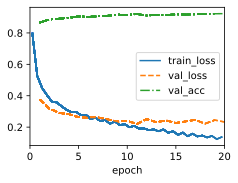

In [8]:
set_seed(SEED) # Set for reproducibility

data = d2l.FashionMNIST(batch_size=128, resize=(28, 28))
trainer = d2l.Trainer(max_epochs=20, num_gpus=1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

## Measure accuracy

In [9]:
set_seed(SEED) # Set for reproducibility

test_iter = data.get_dataloader(train=False)
model.eval()

metric = d2l.Accumulator(2) 

# Test on all batches (TODO: Ask Ms. if there's specific code we need to execute
# to measure accuracy consistently for all groups in our class)
for X, y in test_iter:
    X, y = X.to(d2l.try_gpu()), y.to(d2l.try_gpu())
    metric.add(d2l.accuracy(model(X), y), y.numel())

final_test_acc = metric[0] / metric[1]
print(f'Final Test Accuracy: {final_test_acc:.4f}')

Final Test Accuracy: 0.9242


Expected accuracy: 92.42%